In [1]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import glob
import warnings
import sys
warnings.filterwarnings('ignore')
import argparse
from argparse import RawTextHelpFormatter
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/MO_pipeline/')
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS/')
import utils as ut
import xarray as xr

In [4]:
### extract salt and things
modname = 'TOM12_TJ_1AS1'
def check_progress(modname):
    baseDir = '/gpfs/afm/greenocean/software/runs/'
    path_to_files = f'{baseDir}/{modname}';
    ftype = 'grid_T'
    var = 'vosaline';
    yrstart = 1940
    yrend = 2100
    yrs = np.arange(1940,2101,1)
    indarray, list_of_nanyears = ut.check_for_nans(yrstart,yrend,path_to_files,ftype,var)
    print(list_of_nanyears)

    fact = 0.4
    fig, axs = plt.subplots(1,1, figsize=(20*fact, 6*fact), facecolor='w', edgecolor='k')

    axs.plot(yrs, indarray, 'ro')
    axs.set_title(f'model {modname} Diagnostic - Does model salinity look ok? \n 0=numbers where expected, 1 = nans in model, 2 = file not present')
    axs.grid()
    axs.legend()
    axs.set_xlim([yrstart,yrend])


[2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[]


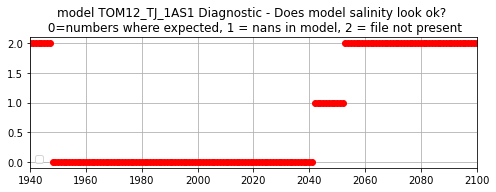

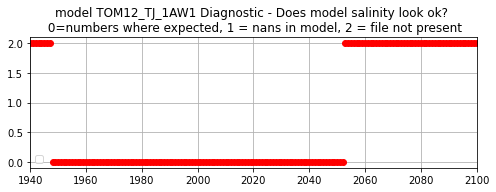

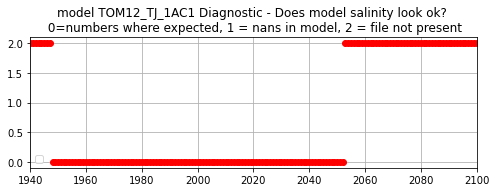

In [5]:
check_progress('TOM12_TJ_1AS1')
check_progress('TOM12_TJ_1AW1')
check_progress('TOM12_TJ_1AC1')